In [3]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import math # for generating real data (points on a circle in this case)

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for data visualizations
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
import plotly
import plotly.express as px # for data visualizations
print('plotly: %s' % plotly.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Tensorflow/Keras: 2.10.0
numpy: 1.23.5
pandas: 1.5.3
matplotlib: 3.7.1
graphviz: 0.20.1
plotly: 5.9.0


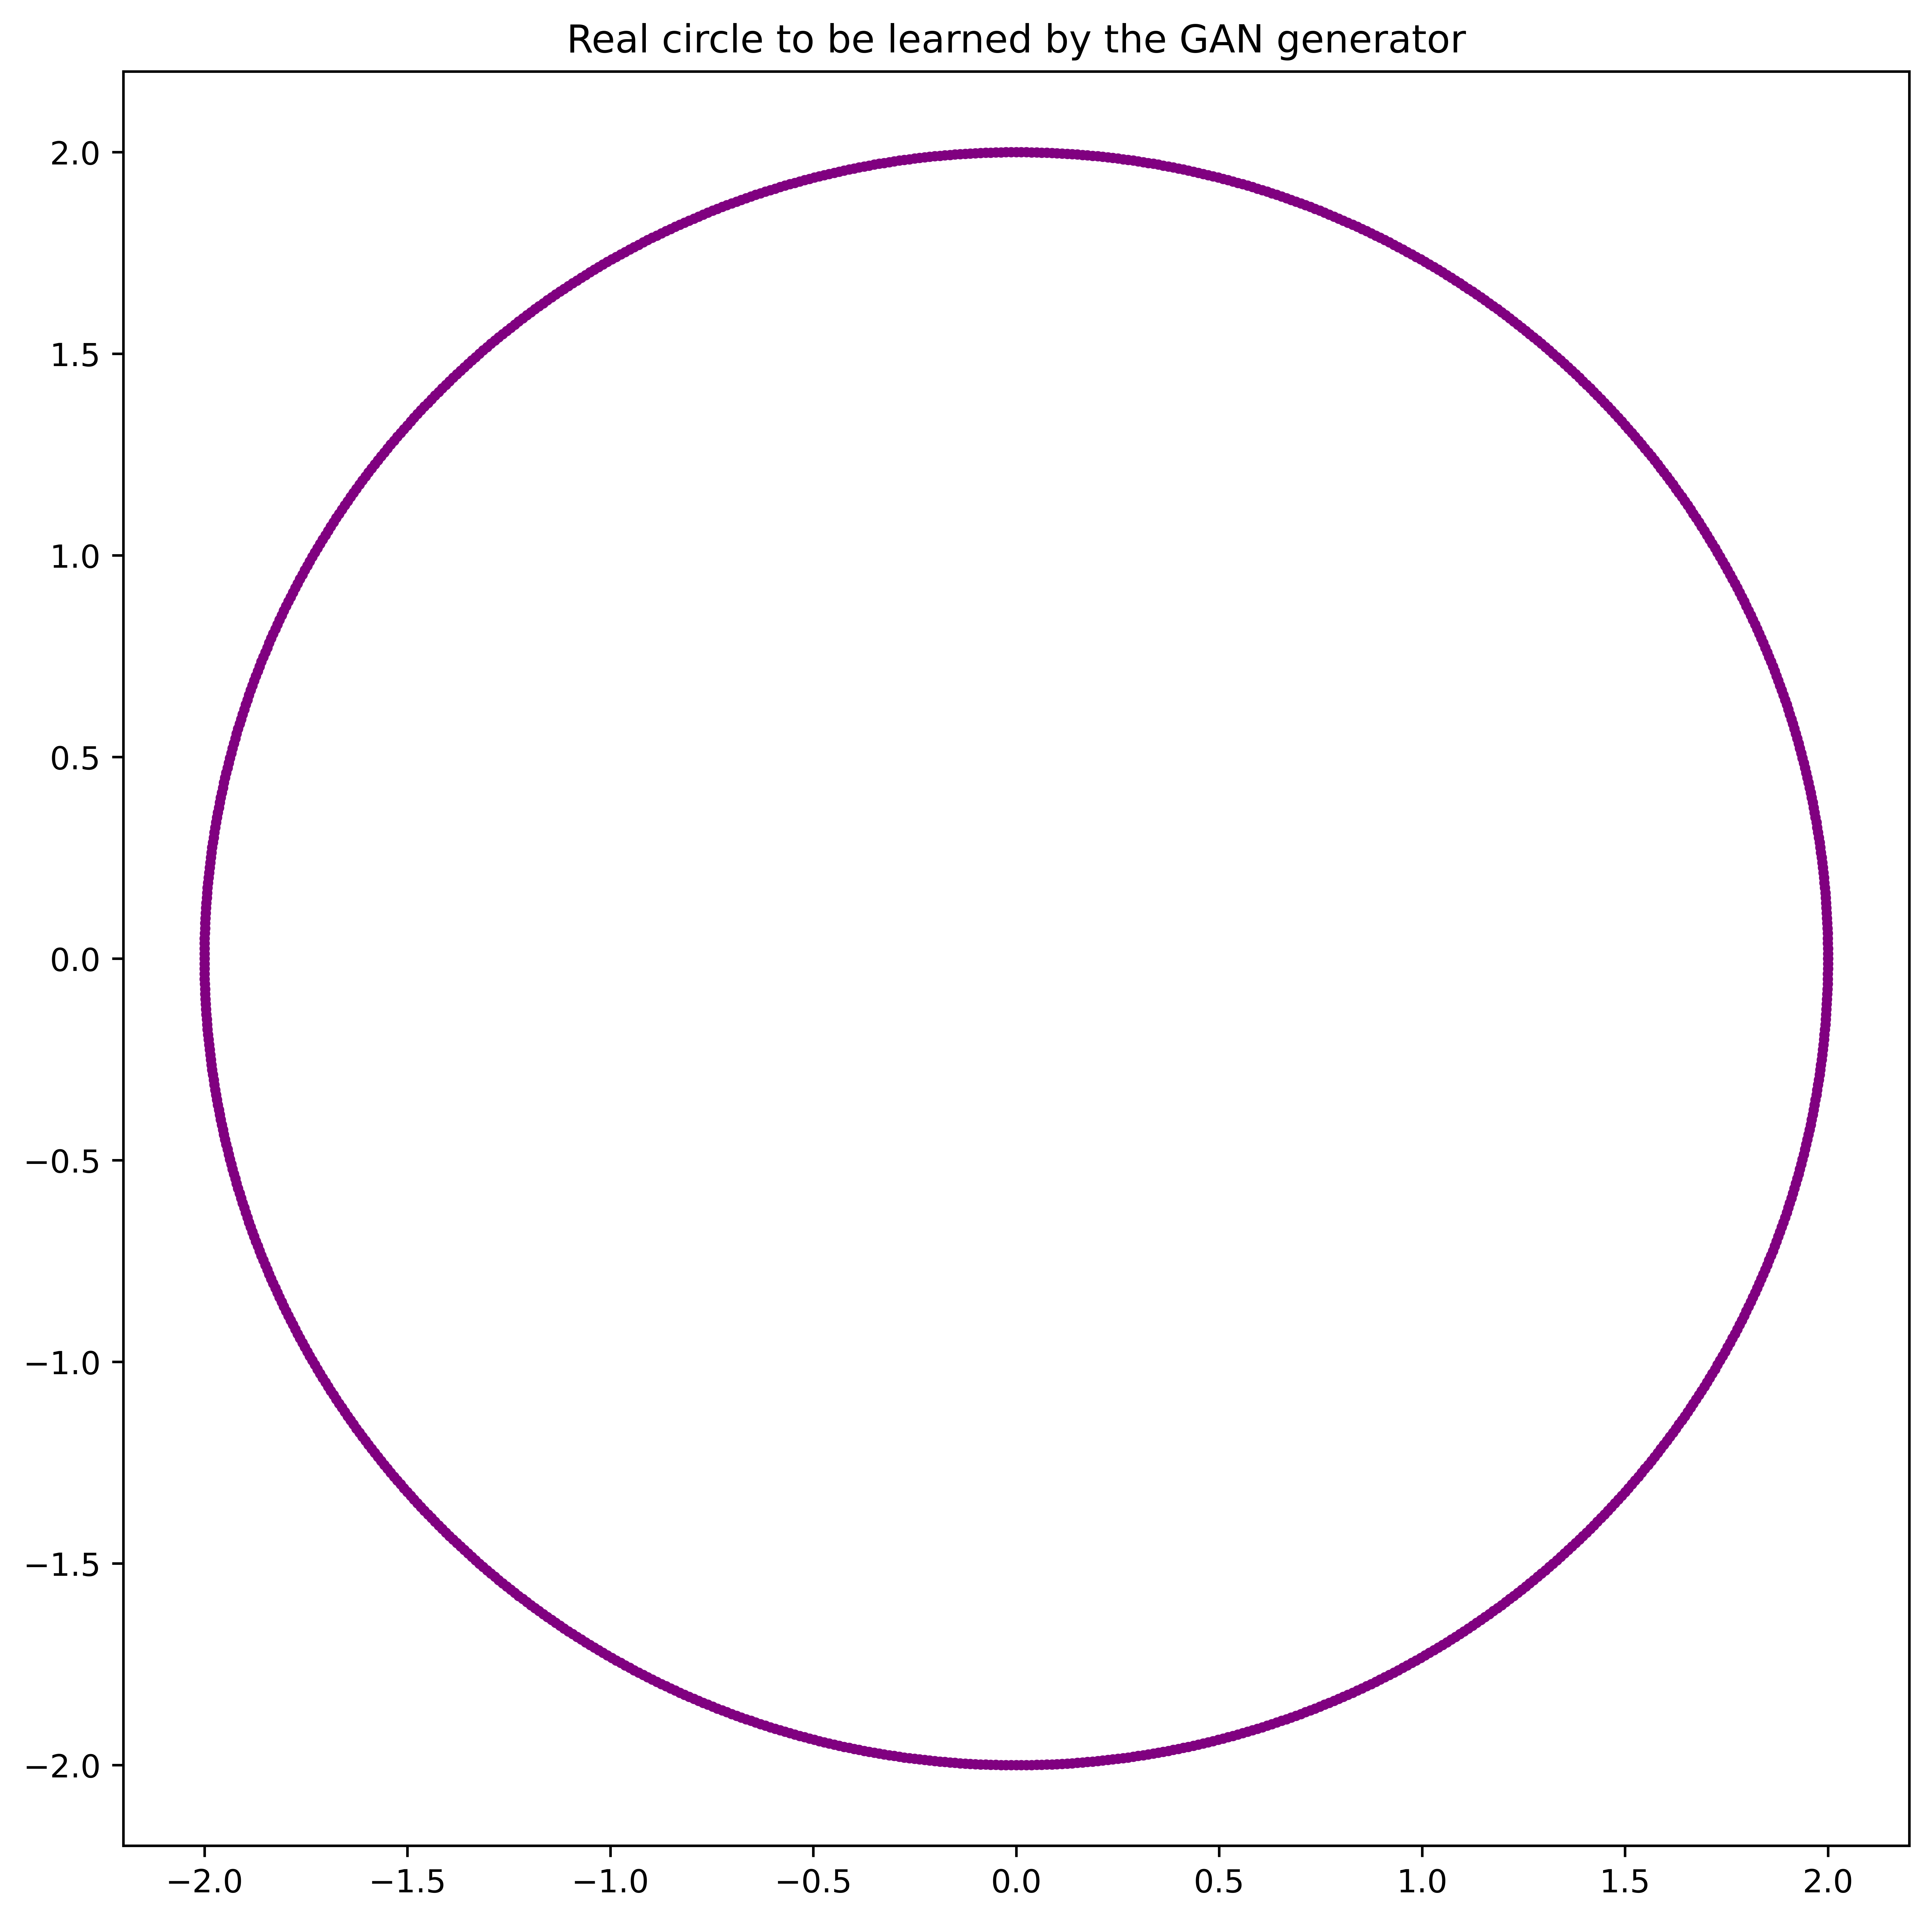

In [11]:
# A function to get coordinates of points on circle's circumference
def PointsInCircum(r,n=100):
    return [(math.cos(2*math.pi/n*x)*r,math.sin(2*math.pi/n*x)*r) for x in range(0,n+1)]

# Save coordinates of a set of real points making up a circle with radius=2
circle=np.array(PointsInCircum(r=2,n=1000))

# Draw a chart
plt.figure(figsize=(10,10), dpi=800)
plt.title(label='Real circle to be learned by the GAN generator', loc='center')
plt.scatter(circle[:,0], circle[:,1], s=5, color='purple')
plt.show()

In [12]:
# Define Generator model
def generator(latent_dim, n_outputs=2):
    model = Sequential(name="Generator") # Model
    
    # Add Layers
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim, name='Generator-Hidden-Layer-1')) # Hidden Layer
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Generator-Hidden-Layer-2')) # Hidden Layer
    model.add(Dense(n_outputs, activation='linear', name='Generator-Output-Layer')) # Output Layer
    return model

# Instantiate
latent_dim=3
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 32)               128       
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-2 (D  (None, 16)               528       
 ense)                                                           
                                                                 
 Generator-Output-Layer (Den  (None, 2)                34        
 se)                                                             
                                                                 
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) 

In [13]:
# Define a Discriminator model
def discriminator(n_inputs=2):
    model = Sequential(name="Discriminator") # Model
    
    # Add Layers
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs, name='Discriminator-Hidden-Layer-1')) # Hidden Layer
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Discriminator-Hidden-Layer-2')) # Hidden Layer
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32)               96        
 1 (Dense)                                                       
                                                                 
 Discriminator-Hidden-Layer-  (None, 16)               528       
 2 (Dense)                                                       
                                                                 
 Discriminator-Output-Layer   (None, 1)                17        
 (Dense)                                                         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/downloa

In [15]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="GAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 2)                 690       
                                                                 
 Discriminator (Sequential)  (None, 1)                 641       
                                                                 
Total params: 1,331
Trainable params: 690
Non-trainable params: 641
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
# Set up a function to sample random points form our circle
def real_samples(n):
    
    # Samples of real data
    X = circle[np.random.choice(circle.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y

  
# Generate points in the latent space, which we will use as inputs for the generator
def latent_points(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

  
# Use the generator to generate n fake examples together with class labels
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_points(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y

In [17]:
def performance_summary(epoch, generator, discriminator, latent_dim, n=100):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=1)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=1)
    
    # summarize discriminator performance
    print("Epoch number: ", epoch)
    print("Discriminator Accuracy on REAL points: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) points: ", fake_accuracy)
    
    # Create a 2D scatter plot to show real and fake (generated) data points
    plt.figure(figsize=(4,4), dpi=150)
    plt.scatter(x_real[:, 0], x_real[:, 1], s=5, color='black')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], s=5, color='red')
    plt.show()

In [18]:

def train(g_model, d_model, gan_model, latent_dim, n_epochs=10001, n_batch=256, n_eval=1000):
    
    # Our batch to train the discriminator will consist of half real points and half fake (generated) points
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
    
    # Generator training
        # Get points from the latent space to be used as inputs for the generator
        x_gan = latent_points(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            performance_summary(i, g_model, d_model, latent_dim)

4/4 [==============================] - 0s 3ms/step - loss: 0.5817 - accuracy: 0.7300
Epoch number:  0
Discriminator Accuracy on REAL points:  0.4000000059604645
Discriminator Accuracy on FAKE (generated) points:  0.7300000190734863


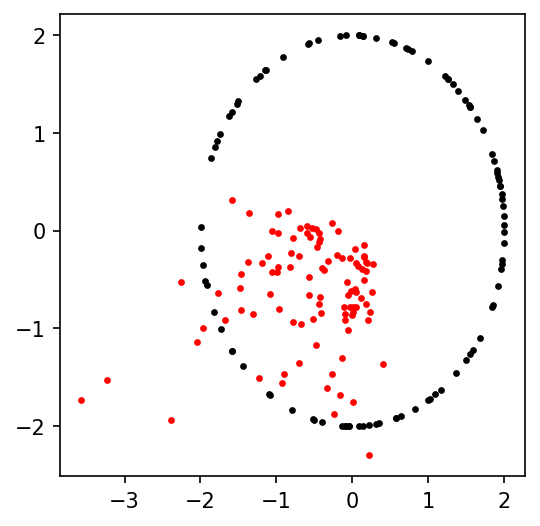

4/4 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.6300
Epoch number:  1000
Discriminator Accuracy on REAL points:  0.3100000023841858
Discriminator Accuracy on FAKE (generated) points:  0.6299999952316284


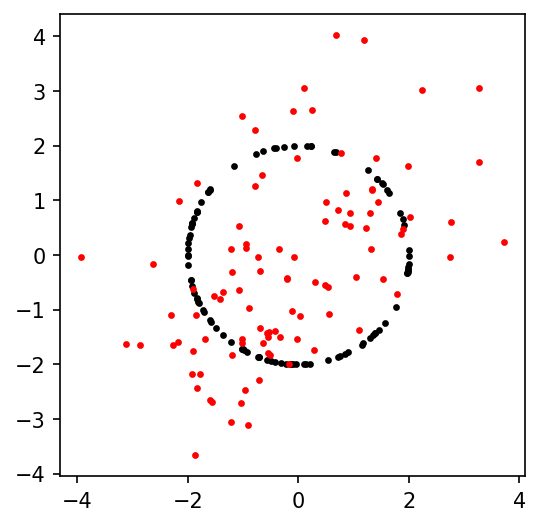

4/4 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6500
Epoch number:  2000
Discriminator Accuracy on REAL points:  0.44999998807907104
Discriminator Accuracy on FAKE (generated) points:  0.6499999761581421


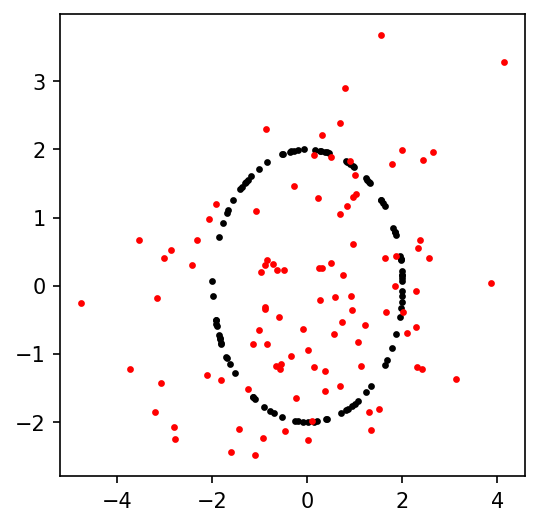

4/4 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6900
Epoch number:  3000
Discriminator Accuracy on REAL points:  0.7799999713897705
Discriminator Accuracy on FAKE (generated) points:  0.6899999976158142


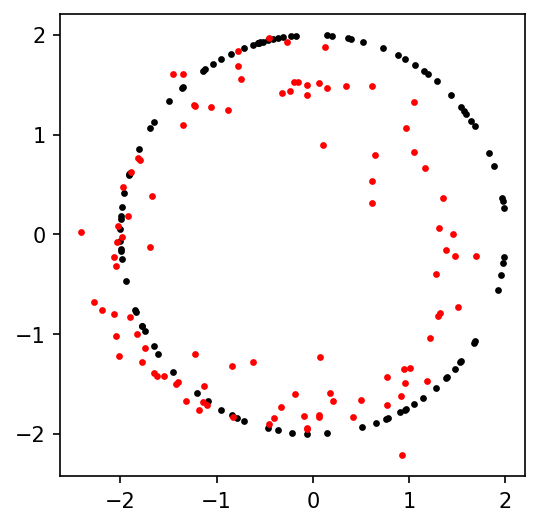

4/4 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.7100
Epoch number:  4000
Discriminator Accuracy on REAL points:  0.5600000023841858
Discriminator Accuracy on FAKE (generated) points:  0.7099999785423279


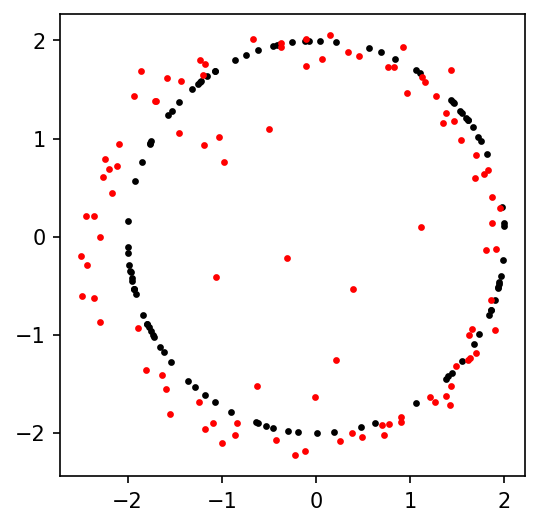

4/4 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.4700
Epoch number:  5000
Discriminator Accuracy on REAL points:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) points:  0.4699999988079071


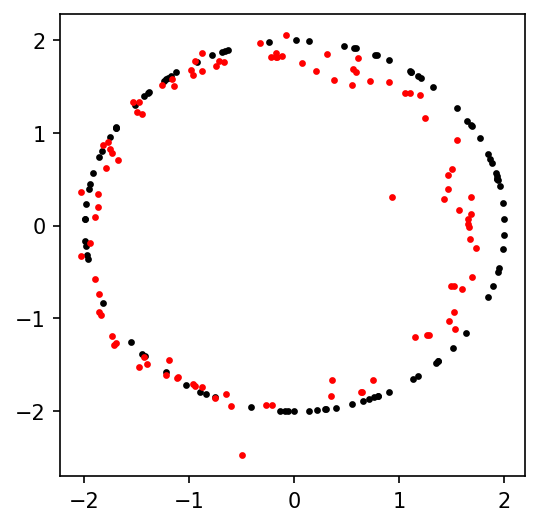

4/4 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.7400
Epoch number:  6000
Discriminator Accuracy on REAL points:  0.800000011920929
Discriminator Accuracy on FAKE (generated) points:  0.7400000095367432


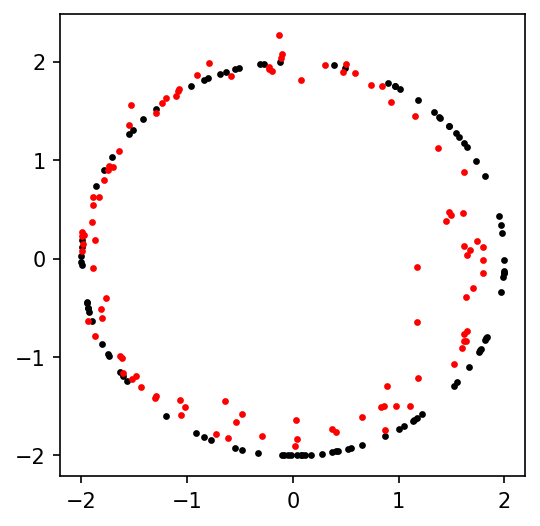

4/4 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.7100
Epoch number:  7000
Discriminator Accuracy on REAL points:  1.0
Discriminator Accuracy on FAKE (generated) points:  0.7099999785423279


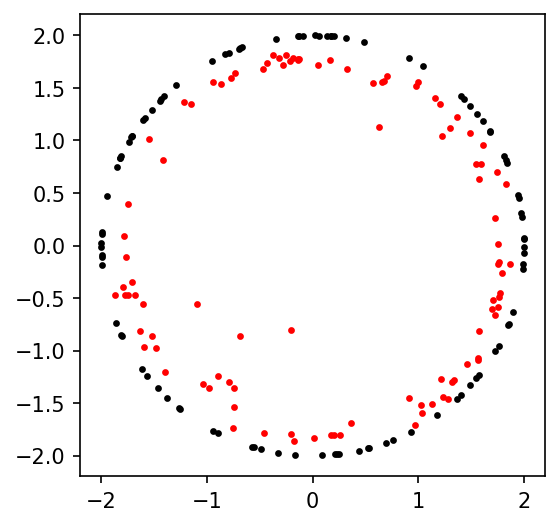

4/4 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.9200
Epoch number:  8000
Discriminator Accuracy on REAL points:  0.28999999165534973
Discriminator Accuracy on FAKE (generated) points:  0.9200000166893005


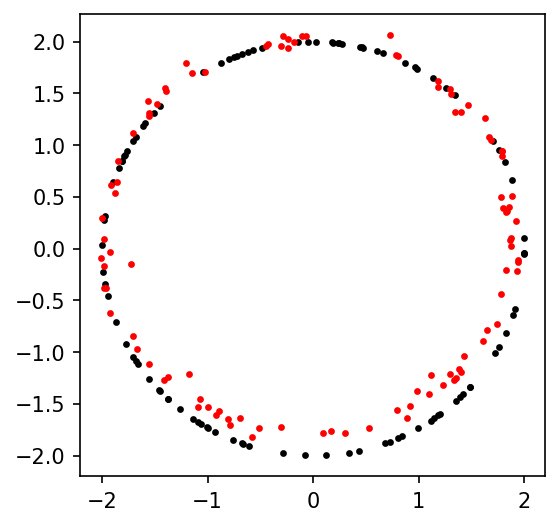

4/4 [==============================] - 0s 3ms/step - loss: 0.5079 - accuracy: 0.9800
Epoch number:  9000
Discriminator Accuracy on REAL points:  0.019999999552965164
Discriminator Accuracy on FAKE (generated) points:  0.9800000190734863


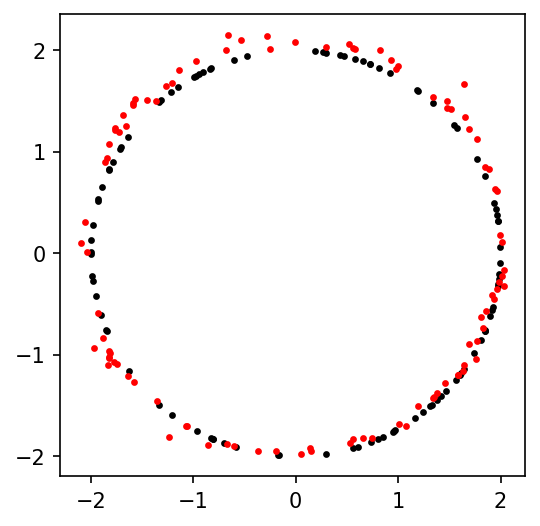

4/4 [==============================] - 0s 3ms/step - loss: 0.8291 - accuracy: 0.0300
Epoch number:  10000
Discriminator Accuracy on REAL points:  1.0
Discriminator Accuracy on FAKE (generated) points:  0.029999999329447746


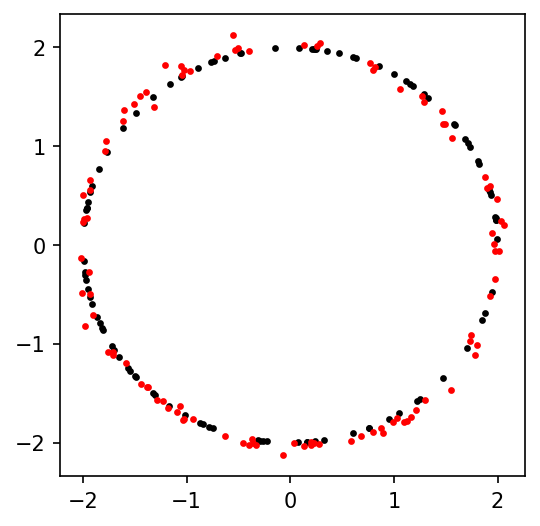

In [19]:
train(gen_model, dis_model, gan_model, latent_dim)

In [20]:
# Generate 1000 fake samples
x_fake, y_fake = fake_samples(gen_model, latent_dim, 1000)
df_fake = pd.DataFrame(x_fake, columns=['x dimension', 'y dimension'])

# Sample 1000 real points
x_real, y_real = real_samples(1000)
df_real = pd.DataFrame(x_real, columns=['x dimension', 'y dimension'])

# Show summary statistics
print("Distribution statistics of fake (generated) points")
print(df_fake.describe())
print("----------------------------------------")
print("Distribution statisticss of real points")
print(df_real.describe())

32/32 [==============================] - 0s 1ms/step
Distribution statistics of fake (generated) points
       x dimension  y dimension
count  1000.000000  1000.000000
mean      0.033344    -0.027144
std       1.448558     1.406050
min      -2.188276    -2.319538
25%      -1.473173    -1.390292
50%       0.099942    -0.032999
75%       1.479160     1.326381
max       2.136027     2.099324
----------------------------------------
Distribution statisticss of real points
       x dimension  y dimension
count  1000.000000  1000.000000
mean      0.057199     0.042487
std       1.396864     1.430976
min      -2.000000    -1.999961
25%      -1.343695    -1.350666
50%       0.100489     0.062822
75%       1.427458     1.510558
max       2.000000     1.999961
